In [1]:
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
np.random.seed(0)

from sklearn.metrics import mean_squared_error
from math import sqrt 

In [2]:
citytemps = pd.read_csv('tempbycity.csv')

In [3]:
citytemps.head()

,tempbycitycsv,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
1,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-04-01,26.14,1.3870000000000000,Abidjan,Côte D'Ivoire,5.63N,3.23W


In [4]:
citytemps = citytemps.rename(columns = {'Unnamed: 1': 'avg_temp', 'Unnamed: 2': 'margoerror', 'Unnamed: 3':'city',
                           'Unnamed: 4':'country', 'Unnamed: 5':'latitude','Unnamed: 6':'longitude', 'tempbycitycsv': 'date'})

In [5]:
citytemps = citytemps.drop(0)

In [6]:
citytemps.head()

,date,avg_temp,margoerror,city,country,latitude,longitude
1,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-04-01,26.14,1.3870000000000000,Abidjan,Côte D'Ivoire,5.63N,3.23W
5,1849-05-01,25.427,1.2,Abidjan,Côte D'Ivoire,5.63N,3.23W


In [7]:
citytemps['date'] = pd.to_datetime(citytemps['date'])

In [8]:
citytemps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239177 entries, 1 to 239177
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        239177 non-null  datetime64[ns]
 1   avg_temp    228175 non-null  object        
 2   margoerror  228175 non-null  object        
 3   city        239177 non-null  object        
 4   country     239177 non-null  object        
 5   latitude    239177 non-null  object        
 6   longitude   239177 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 12.8+ MB


In [9]:
citytemps['avg_temp'] = citytemps.avg_temp.astype(float)

In [10]:
citytemps = citytemps.set_index(citytemps['date'])

In [11]:
citytemps.head()

,date,avg_temp,margoerror,city,country,latitude,longitude
date,,,,,,,
1849-01-01,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1849-02-01,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
1849-03-01,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
1849-04-01,1849-04-01,26.140,1.3870000000000000,Abidjan,Côte D'Ivoire,5.63N,3.23W
1849-05-01,1849-05-01,25.427,1.2,Abidjan,Côte D'Ivoire,5.63N,3.23W


In [12]:
citytemps = citytemps.drop(columns = 'date')
citytemps

,avg_temp,margoerror,city,country,latitude,longitude
date,,,,,,
1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
1849-04-01,26.140,1.3870000000000000,Abidjan,Côte D'Ivoire,5.63N,3.23W
1849-05-01,25.427,1.2,Abidjan,Côte D'Ivoire,5.63N,3.23W
...,...,...,...,...,...,...
2013-05-01,18.979,0.807,Xian,China,34.56N,108.97E
2013-06-01,23.522,0.647,Xian,China,34.56N,108.97E
2013-07-01,25.251,1.042,Xian,China,34.56N,108.97E


In [13]:
citytemps.city.unique()

array(['Abidjan', 'Addis Abeba', 'Ahmadabad', 'Aleppo', 'Alexandria',
       'Ankara', 'Baghdad', 'Bangalore', 'Bangkok', 'Belo Horizonte',
       'Berlin', 'Bogotá', 'Bombay', 'Brasília', 'Cairo', 'Calcutta',
       'Cali', 'Cape Town', 'Casablanca', 'Changchun', 'Chengdu',
       'Chicago', 'Chongqing', 'Dakar', 'Dalian', 'Dar Es Salaam',
       'Delhi', 'Dhaka', 'Durban', 'Faisalabad', 'Fortaleza', 'Gizeh',
       'Guangzhou', 'Harare', 'Harbin', 'Ho Chi Minh City', 'Hyderabad',
       'Ibadan', 'Istanbul', 'Izmir', 'Jaipur', 'Jakarta', 'Jiddah',
       'Jinan', 'Kabul', 'Kano', 'Kanpur', 'Karachi', 'Kiev', 'Kinshasa',
       'Lagos', 'Lahore', 'Lakhnau', 'Lima', 'London', 'Los Angeles',
       'Luanda', 'Madras', 'Madrid', 'Manila', 'Mashhad', 'Melbourne',
       'Mexico', 'Mogadishu', 'Montreal', 'Moscow', 'Nagoya', 'Nagpur',
       'Nairobi', 'Nanjing', 'New Delhi', 'New York', 'Paris', 'Peking',
       'Pune', 'Rangoon', 'Rio De Janeiro', 'Riyadh', 'Rome', 'São Paulo',
       'S

In [14]:
citytemps = citytemps.dropna()

In [15]:
chitemps = citytemps[citytemps['city'] == 'Chicago']
chitemps

,avg_temp,margoerror,city,country,latitude,longitude
date,,,,,,
1743-11-01,5.436,2.205,Chicago,United States,42.59N,87.27W
1744-04-01,8.766,2.357,Chicago,United States,42.59N,87.27W
1744-05-01,11.605,2.102,Chicago,United States,42.59N,87.27W
1744-06-01,17.965,1.989,Chicago,United States,42.59N,87.27W
1744-07-01,21.680,1.786,Chicago,United States,42.59N,87.27W
...,...,...,...,...,...,...
2013-05-01,13.734,0.863,Chicago,United States,42.59N,87.27W
2013-06-01,17.913,0.669,Chicago,United States,42.59N,87.27W
2013-07-01,21.914,0.322,Chicago,United States,42.59N,87.27W


In [16]:
chitemps.isnull().sum()

avg_temp      0
margoerror    0
city          0
country       0
latitude      0
longitude     0
dtype: int64

In [17]:
chitemps.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3141 entries, 1743-11-01 to 2013-09-01
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   avg_temp    3141 non-null   float64
 1   margoerror  3141 non-null   object 
 2   city        3141 non-null   object 
 3   country     3141 non-null   object 
 4   latitude    3141 non-null   object 
 5   longitude   3141 non-null   object 
dtypes: float64(1), object(5)
memory usage: 171.8+ KB


In [18]:
chitemps.drop(columns = ['margoerror', 'city', 'country', 'latitude', 'longitude'], inplace = True)

In [19]:
tempsonly = chitemps.resample('Y').mean()


In [20]:
#dropping null
tempsonly = tempsonly.dropna()

In [34]:
tempsonly

,avg_temp
date,
1743-12-31,5.436000
1744-12-31,11.731875
1745-12-31,1.799000
1750-12-31,10.485909
1751-12-31,11.192875
...,...
2009-12-31,10.298333
2010-12-31,11.815917
2011-12-31,11.214250


In [35]:
train_size = .7
n = tempsonly.shape[0]
test_start_date = int(train_size * n)
test_start_date

186

In [36]:
train = tempsonly[:186]
test = tempsonly[186:]

In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 186 entries, 1743-12-31 to 1932-12-31
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   avg_temp  186 non-null    float64
dtypes: float64(1)
memory usage: 2.9 KB


In [38]:
train

,avg_temp
date,
1743-12-31,5.436000
1744-12-31,11.731875
1745-12-31,1.799000
1750-12-31,10.485909
1751-12-31,11.192875
...,...
1928-12-31,10.205417
1929-12-31,9.284000
1930-12-31,10.786750


In [39]:
test

,avg_temp
date,
1933-12-31,11.086000
1934-12-31,10.874000
1935-12-31,10.008833
1936-12-31,9.856917
1937-12-31,9.993750
...,...
2009-12-31,10.298333
2010-12-31,11.815917
2011-12-31,11.214250


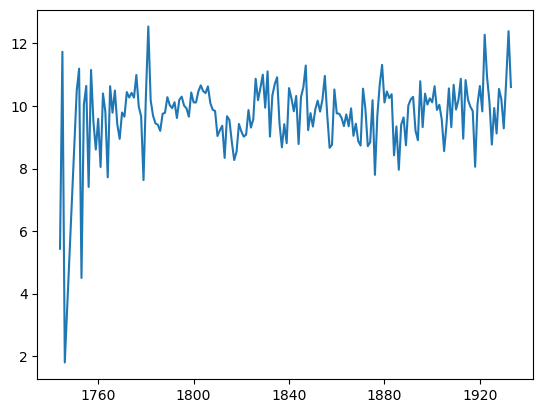

In [40]:
plt.plot(train.index, train['avg_temp'])
plt.show()

In [41]:
train.isnull().sum()

avg_temp    0
dtype: int64

In [42]:
import evaluate

# Simple Average Model

In [43]:
#finding average of chi temp

avg_total_temp = round(chitemps['avg_temp'].mean(), 2)
avg_total_temp

10.07

In [44]:
yhat_df = pd.DataFrame({'avg_temp':[avg_total_temp]}, index=test.index)
yhat_df

,avg_temp
date,
1933-12-31,10.07
1934-12-31,10.07
1935-12-31,10.07
1936-12-31,10.07
1937-12-31,10.07
...,...
2009-12-31,10.07
2010-12-31,10.07
2011-12-31,10.07


Text(0.5, 1.0, 'Average temp in Chicago')

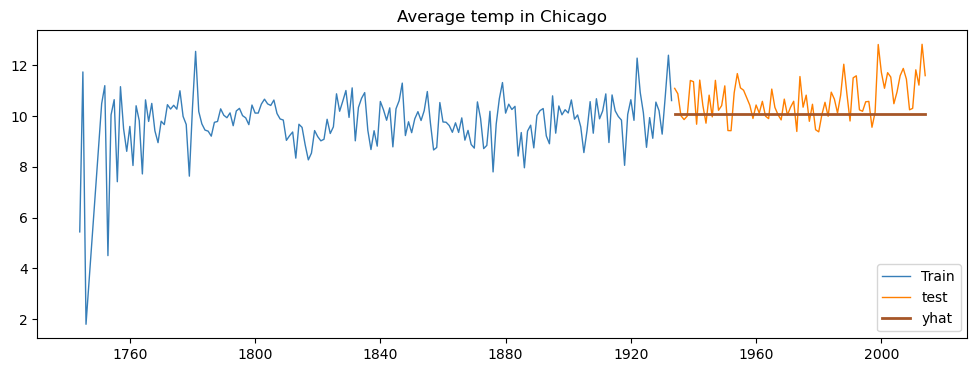

In [50]:
plt.figure(figsize = (12,4))
plt.plot(train.index, train['avg_temp'], label='Train', linewidth=1, color='#377eb8')
plt.plot(test['avg_temp'], label='test', linewidth=1, color='#ff7f00')
plt.plot(yhat_df['avg_temp'], label='yhat', linewidth=2, color='#a65628')
plt.legend()
plt.title('Average temp in Chicago')
